In this study, a small vision tranformer (ViT) [1] will be implemented in PyTorch. During this study, the following architecture will be followed:

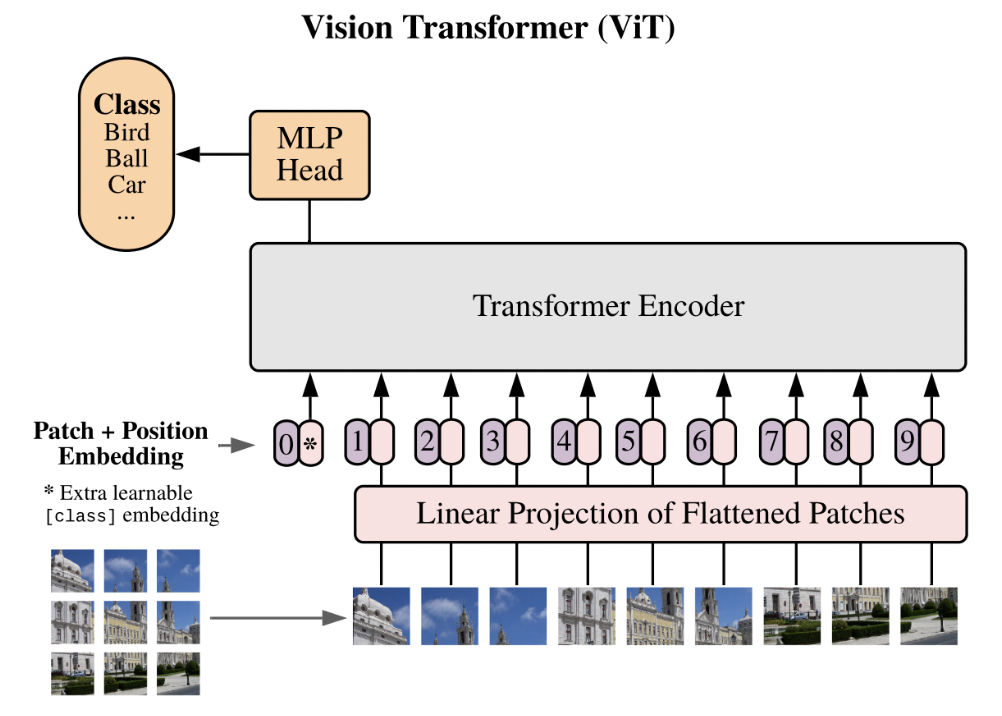

Reference:

[1] Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S. and Uszkoreit, J., 2020. An image is worth 16x16 words: Transformers for image recognition at scale. ICLR 2021. https://arxiv.org/abs/2010.11929

In [1]:
# create some crucial functions for transformer architecture

import torch.nn as nn

def patchify(images, patch_size = 7):
  """It takes images with a shape of (N,C,H,W), and it divides images
  into the specific patches using patch_size parameter. It provides an
  output tensor whose patches are flattened.
  Parameters:
    Input:
      images: (N,C,H,W) tensors
      patch_size: each side of a patch
    Output:
      patches: (N, num_patch, num_elem)
  """
  img_shape = images.shape #batch, channel, height, width
  n_batch = img_shape[0]
  n_channel = img_shape[1]
  h = img_shape[2]
  w = img_shape[3]

  #initialize tensor of zeros
  patches = torch.zeros(n_batch, (h*w)//(patch_size**2), patch_size**2)
  num_patch = h // patch_size

  for id, each_image in enumerate(images):
    row=0
    ind=0
    for i in range(1, num_patch+1):
      col=0
      for j in range(1, num_patch+1):
        patch = each_image[:,row:patch_size*i, col:patch_size*j]
        patches[id, ind] = patch.flatten()
        ind += 1
        col += patch_size
      row += patch_size

  return patches

def positional_encoding(num_patch=4):
  """It provides positional information of the patches for the given images.
  Parameters:
    Input:
      num_patch: number of patches for each side
    Output:
      res: (num_patch**2, num_patch*2) vector, that includes position of a
          patch. i.e. [1,0,0,0,1,0,0,0] for the 1st row 1st column patch
  """

  res = torch.zeros(num_patch**2, 2*num_patch)
  i = 0
  for x in range(num_patch):
    for y in range(num_patch):
      pos=torch.zeros(8)
      pos[x], pos[y+4] = 1, 1
      res[i] = pos
      i += 1

  return res

class MHA(nn.Module): #multi-head attention
  """It applies multi-head attention algorithm to use in transformer encoder
  Parameters:
    Input:
      dimen: input dimension
      num_head: number of head of the self-attention mechanism
  """
  
  def __init__(self, dimen=8+8, num_head=2):
    super(MHA, self).__init__()
    self.dimen = dimen
    self.num_head = num_head
    self.head_dim = int(dimen/num_head)
    
    #create query, key, value linear mappings
    self.q_map = nn.ModuleList([nn.Linear(self.head_dim, self.head_dim) for _ in range(self.num_head)])
    self.k_map = nn.ModuleList([nn.Linear(self.head_dim, self.head_dim) for _ in range(self.num_head)])
    self.v_map = nn.ModuleList([nn.Linear(self.head_dim, self.head_dim) for _ in range(self.num_head)])
    self.softmax = nn.Softmax(dim=-1) 
    
  def forward(self, patch_sequences):
    results = []
    for each_seq in patch_sequences:
      #each_seq.shape: (256, 16, 16)
      seq_results = []
      for head in range(self.num_head):
        q_mapping = self.q_map[head]
        k_mapping = self.k_map[head]
        v_mapping = self.v_map[head]

        seq = each_seq[:, head*self.head_dim: (head+1)*self.head_dim]
        q = q_mapping(seq)
        k = k_mapping(seq)
        v = v_mapping(seq)

        attention = self.softmax(q @ k.T / (self.head_dim ** 0.5)) #apply softmax(Q.KT/sqrt(dk))
        seq_results.append(attention @ v) #apply softmax(Q.KT/sqrt(dk)).V
      results.append(torch.hstack(seq_results))
      output = torch.cat([torch.unsqueeze(x, dim=0) for x in results])
    return output

class ResBlock(nn.Module):
  """It applies basic skip-connection firstly used in ResNet, and it 
  add multi-perceptron (2 layers).
  """
  
  def __init__(self, hidden_d=8+8, n_heads=2, mlp_ratio=5):
    super(ResBlock, self).__init__()
    self.hidden_d = hidden_d
    self.n_heads = n_heads
    self.mlp_ratio = mlp_ratio

    self.normalization_1 = nn.LayerNorm(self.hidden_d) #normalization mention in the transformer encoder
    self.normalization_2 = nn.LayerNorm(self.hidden_d)
    self.multihead = MHA(dimen=self.hidden_d, num_head=self.n_heads)
    self.MLP = nn.Sequential(nn.Linear(self.hidden_d, mlp_ratio*self.hidden_d),
                             nn.ReLU(),
                             nn.Linear(mlp_ratio*self.hidden_d, hidden_d)
                             )
    
  def forward(self, x):
    out = x + self.multihead(self.normalization_1(x))
    out = out + self.MLP(self.normalization_2(out))
    return out


class VisTrans(nn.Module):
  """It is a Visual Transformer that uses images as input in order to apply a
  classification model
  """

  def __init__(self, D=8, batch_size=256, hidden_d=8+8, n_heads=2, out_dimen=10):
    super(VisTrans, self).__init__()

    self.D = D
    self.batch_size = batch_size
    self.hidden_d = hidden_d
    self.n_heads = n_heads
    self.out_dimen = out_dimen #number of classes

    #create a linear layer
    self.input = 1*7*7 #channel*patch_size*patch_size
    self.linear_layer = nn.Linear(self.input, self.D) # 49->8

    #positional embedding
    self.pos_encod = nn.Parameter(positional_encoding())
    self.pos_encod.requires_grad = False

    #transformer encoder
    self.encoder = nn.ModuleList([ResBlock(self.hidden_d, n_heads)]) #1 encoder block
    
    #outer mlp classification layer
    self.mlp = nn.Sequential(nn.Linear(self.hidden_d, self.out_dimen),
                             nn.Softmax(dim=-1))

  def forward(self, images):

    patches = patchify(images)
    tokens = self.linear_layer(patches)

    #concatenate positional embeddings with current token(output of linear layer)
    pos_embedding = self.pos_encod.repeat(images.shape[0], 1, 1)
    out = torch.cat((pos_embedding, tokens), dim=2) #shape=(256, 16, 8+8)

    #transformer
    for encoder in self.encoder:
      out = encoder(out)

    #get only the classification token 
    out = out[:, 0]
    final_result = self.mlp(out)
    
    return final_result

In [6]:
# import the appropriate packages 
from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

# Loading data
dataset = datasets.MNIST(root='./../datasets', train=False, download=True, transform=transforms.ToTensor())
data_loader = DataLoader(dataset, shuffle=True, batch_size=256)

# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisTrans().to(device)

num_epochs = 5
lr = 0.005

In [7]:
# Training the model
optimizer = Adam(model.parameters(), lr=lr)
criterion = CrossEntropyLoss()
losses = []
for epoch in range(num_epochs):
    train_loss = 0.0
    for it, batch in enumerate(data_loader): 
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        loss_val = loss.detach().cpu().item()
        train_loss += loss_val / len(data_loader)
        losses.append(loss_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs} loss: {train_loss:.2f}")

Epoch 1/5 loss: 2.20
Epoch 2/5 loss: 1.96
Epoch 3/5 loss: 1.90
Epoch 4/5 loss: 1.84
Epoch 5/5 loss: 1.82


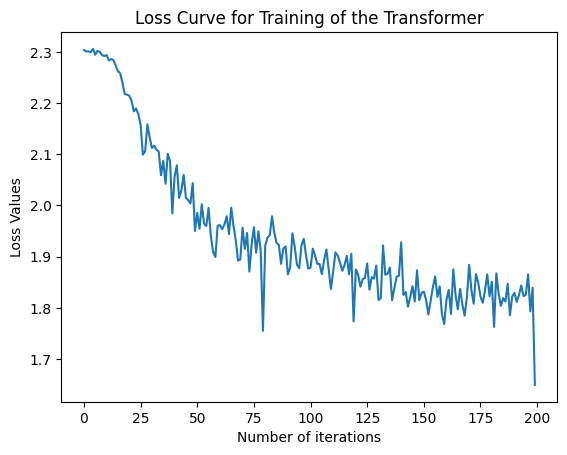

In [8]:
# plot the training loss curve

from matplotlib import pyplot as plt

plt.plot(losses)
plt.xlabel("Number of iterations")
plt.ylabel("Loss Values")
plt.title("Loss Curve for Training of the Transformer")
plt.show()